## Visualisation 2

This notebook will focus on displaying multivariate data, clustering, PCA and figure composition. DAta to be used are either synthetic or previoursly used datasets (wine).

In [1]:
# Imports and plotting defaults
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage

from sklearn.datasets import load_wine



In [2]:

sns.set_theme(style='whitegrid', context='talk')
plt.rcParams['figure.dpi'] = 120


In [3]:
# Load wine dataset
wine = load_wine(as_frame=True)
df = wine.frame  # includes features + target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### Visualising multivariate data

#### 1. Pairplots

Improve the bad looking pairplot for the wine dataset!

In [ ]:
sns.pairplot(df)
plt.show()

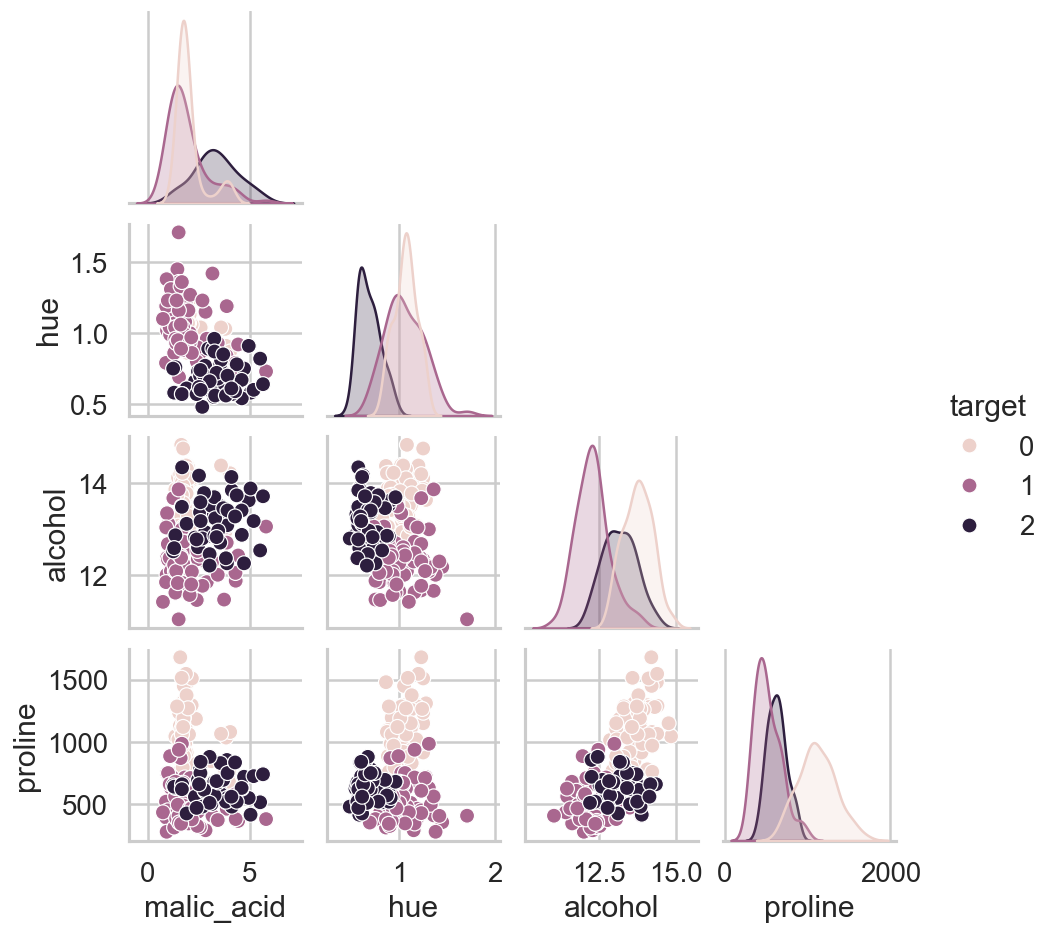

In [10]:
sns.pairplot(
    df,
    vars=["malic_acid", "hue", "alcohol", "proline"],
    hue="target",
    diag_kind="kde",
    corner=True,
    # palette="viridis",
    height=2
)
plt.show()

#### 2. FacetGrids

Explore the examples for some facet plots below. Note the different forms of input and play around with some options. Think about what you could derive from the plots.

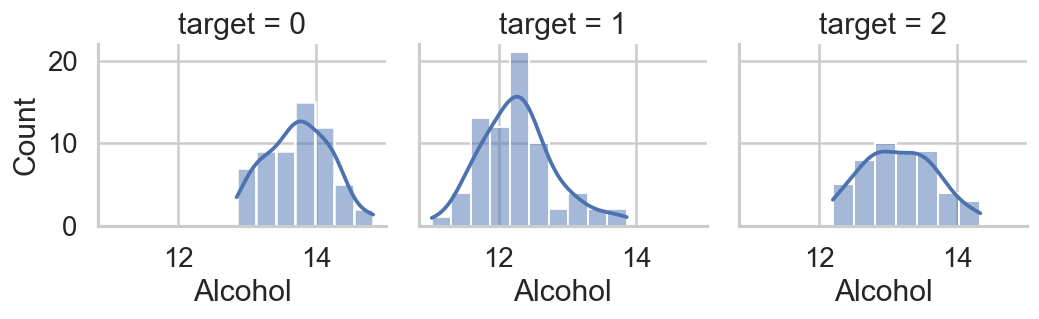

In [15]:
# Histograms as first example
g = sns.FacetGrid(df, col="target", sharex=True, sharey=True)
g.map_dataframe(sns.histplot, x="alcohol", kde=True)
g.set_axis_labels("Alcohol", "Count")
plt.show()

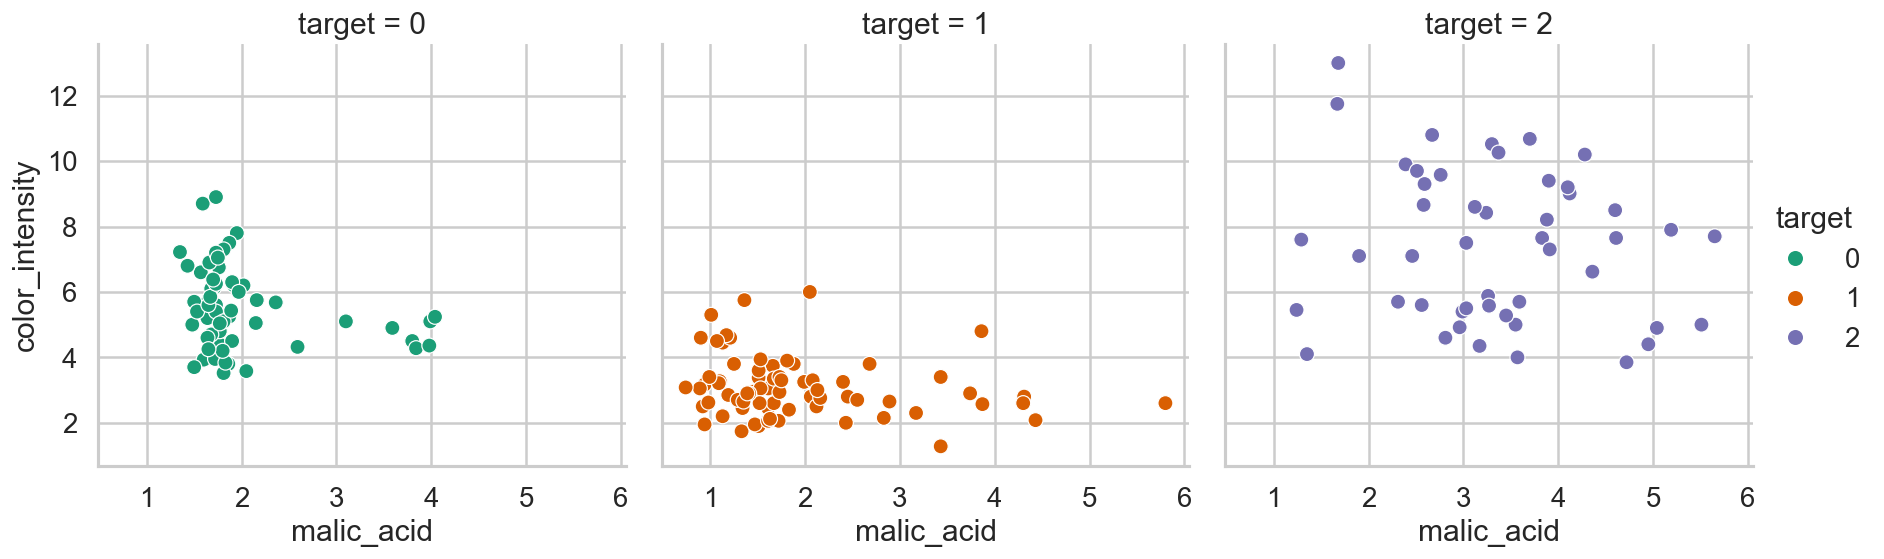

In [12]:
# More control over various options: Scatterplots as FacetGrid
sns.relplot(
    data=df,
    x="malic_acid",
    y="color_intensity",
    col="target",
    kind="scatter",
    hue="target",
    palette="Dark2",
    col_wrap=3
)
plt.show()

### 3. Dimensionality reduction
Run the example for PCA and t-SNE for dimensionality reduction. 

Discuss the following questions:
- Why does t-SNE group the clusters into narrower islands?
- Why are the distances between t-SNE clusters not scientific measurements?
- Why is PCA often one of the first methods applied in Lifescience problems?

Play with the hyperparameters and see how the result changes.

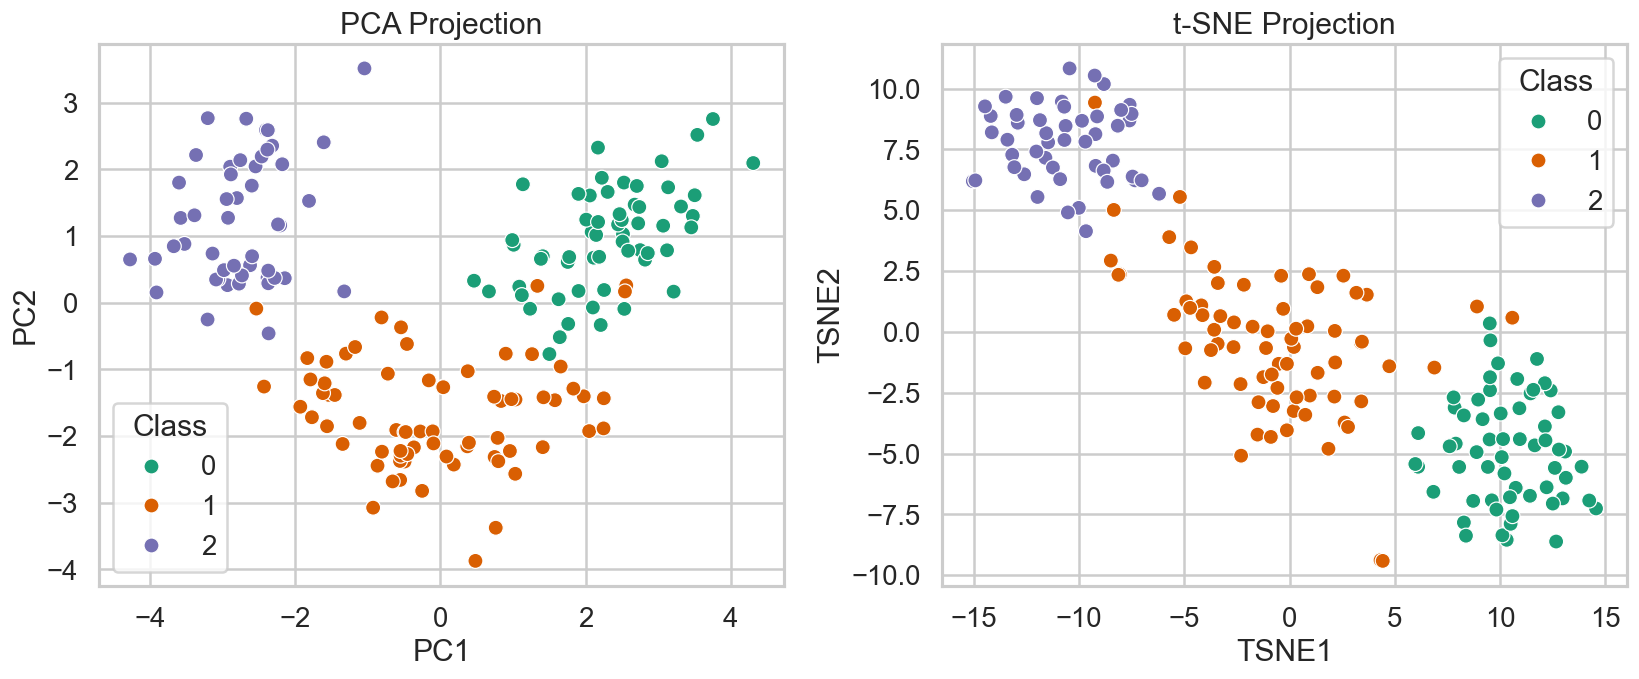

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Prepare dataset
X = df.drop(columns=["target"])
y = df["target"]

# Standardise features
X_scaled = StandardScaler().fit_transform(X)

# PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE to 2 components
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Combine results in one DataFrame
plot_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "TSNE1": X_tsne[:, 0],
    "TSNE2": X_tsne[:, 1],
    "Class": y
})

# Visualise PCA and t-SNE results in one plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="Class", palette="Dark2", ax=ax[0])
ax[0].set_title("PCA Projection")

sns.scatterplot(data=plot_df, x="TSNE1", y="TSNE2", hue="Class", palette="Dark2", ax=ax[1])
ax[1].set_title("t-SNE Projection")

plt.tight_layout()
plt.show()

### 4. K-Means clustering and PCA visualisation

Identify clusters using the k-means algorithm in the snippet below. This algortihm works in high.dimensional space and therefore to visualise, you have to run a PCA.

Select different Ks (i.e. n_clusters) and see what happens. Before continuing run the cell with k=3 again.

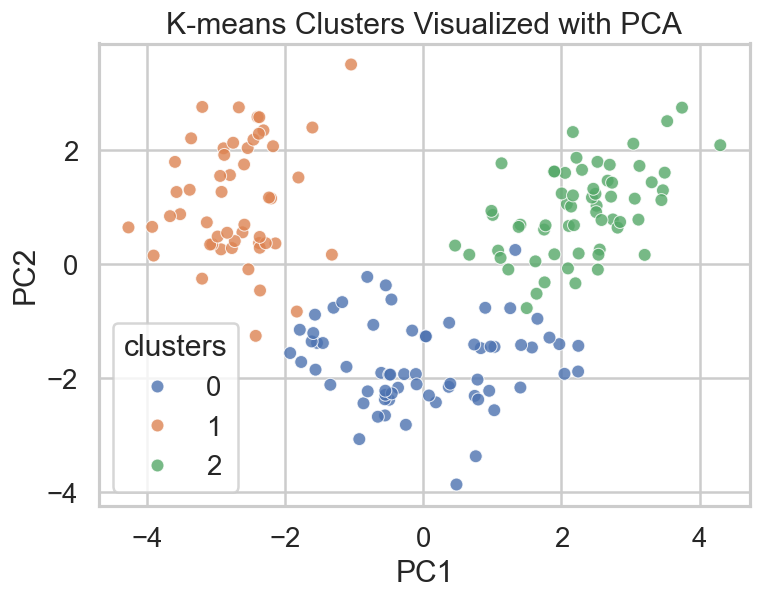

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# standardise features:
df_scaled = (df[wine.feature_names] - df[wine.feature_names].mean()) / df[wine.feature_names].std()

# K-means on raw-standardised features
kmeans = KMeans(n_clusters=3, random_state=1)
df["kmeans_label"] = kmeans.fit_predict(df_scaled)

# PCA for visualisation
pca = PCA(n_components=2)
components = pca.fit_transform(df_scaled)

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=components[:, 0],
    y=components[:, 1],
    hue=df["kmeans_label"],
    palette="deep",
    s=60,
    alpha=0.8
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="best", title="clusters")
plt.title("K-means Clusters Visualized with PCA")
plt.show()


To compare the K-means clusters to the true wine classes in the dataset, run the following code. What do you conclude?

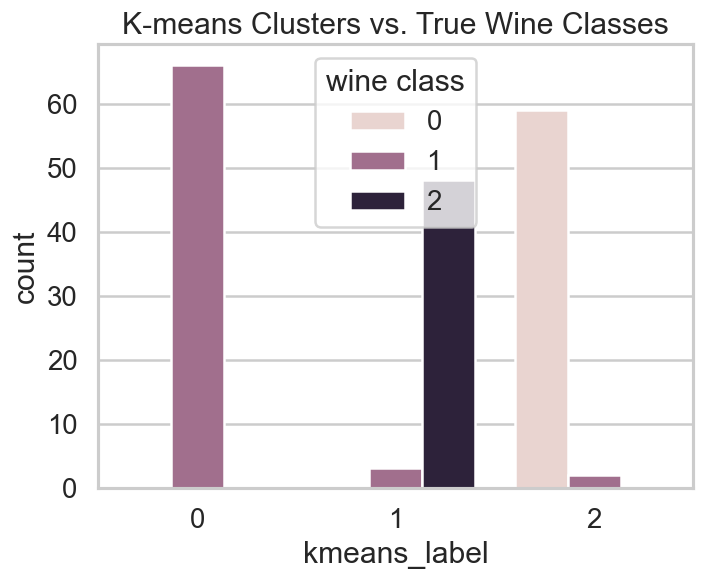

In [24]:
# visually:
sns.countplot(x="kmeans_label", hue="target", data=df)
plt.title("K-means Clusters vs. True Wine Classes")
plt.legend(loc="upper center", title="wine class")
plt.show()


### 5. Hierarchical clustering

Use the seaborn `clustermap` to perform a hierarchical clustering on the scaled dataframe, which will result in the following:
- Samples (rows) are grouped into hierarchical clusters based on all features.
- Heatmap blocks reveal groups of chemically similar wines.
- Dendrogram height shows cluster distances.

Tasks:
- Identify major branches → main groups
- Then locate heatmap blocks: Dark/light patches → high/low values in particular variables
- Check variable dendrogram: Which variables behave similarly? Correlated variables cluster together
- Colour scaling matters: Perceptually-uniform colormaps (e.g., “vlag” or “coolwarm”) preserve meaning


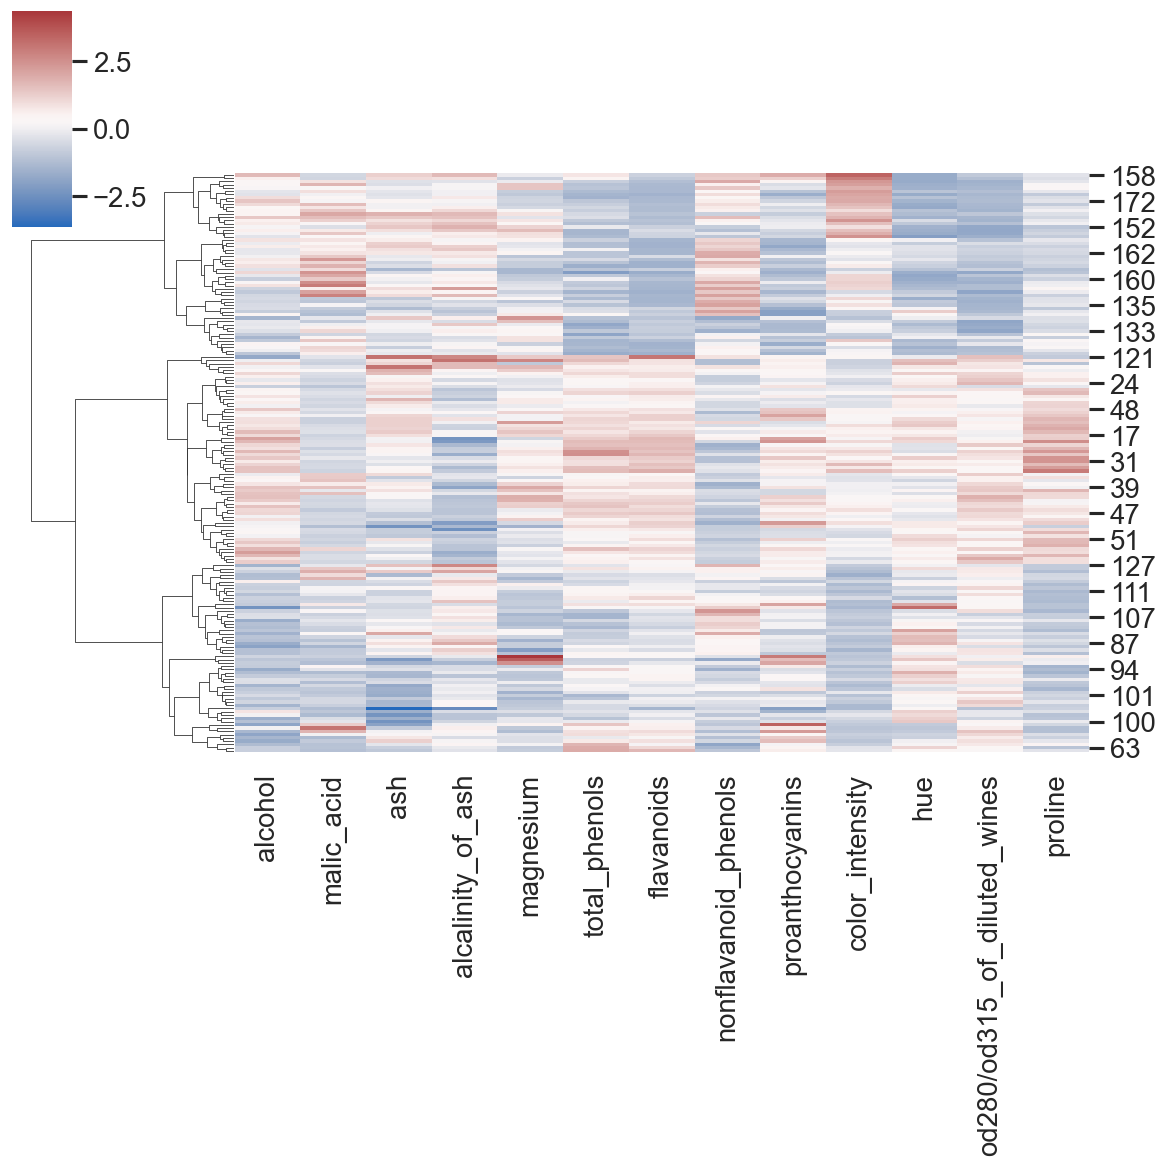

In [25]:
sns.clustermap(df_scaled, 
               cmap="vlag", 
               figsize=(10, 10),
               method="ward",
               col_cluster=False)  # cluster samples only
plt.show()

Run the following snippet to only display the dendrograms.

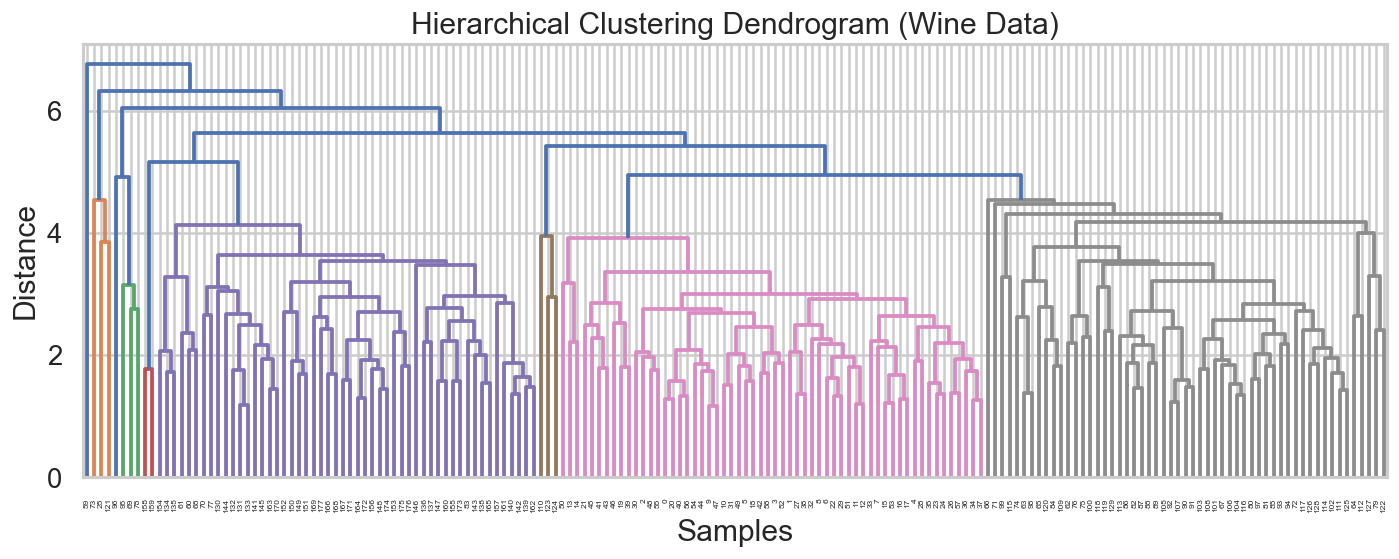

In [28]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute linkage matrix
Z = linkage(df_scaled, method="average")

plt.figure(figsize=(12, 5))
dendrogram(Z, labels=df.index.astype(str), leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram (Wine Data)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


#### Task: Rerun hierarchical clustering with a selection of features. 

Select from the wine dataset a few features and create a seaborn `clustermap`. Do not forget to scale your selected features!

- How many major clusters do you see in the dendrogram?
- Which features appear to behave similarly?

See how different linkage methods change the outcome. Try "single" and "average".

Compare how this with the k-means clustering. Which method works better?

In [ ]:
subset = ["alcohol", ""]
df


### 6. TASKS: Visualisation synopsis 

#### Task 1: Flash-plot
You get 3 minutes of time to choose 2 features from the wine dataset and create an “insightful plot” (can be relatively crude and suboptimal).

Questions afterwards: 
- Why this plot? 
- What does it reveal?
- What alternative would work better?


#### Task 2: Mini-project visualisation

Produce one publication-quality multi-panel figure from a previously used dataset, e.g. `wine_df`, meeting these requirements:
- Include at least one clustered heatmap or dimensionality reduction (PCA).
- Visualise uncertainty where relevant (shaded CI or error bars).
- Use accessible color palettes and add clear axis labels with units.
- Provide a 2–3 sentence figure caption explaining the scientific message and summarizing analytical choices.